# Compare K-Means Seeding Against Choosing N Points at Random

K-means++ maximises the spread between N centroids, and does so according to a weight function.
ADD IMAGE HERE

Things to Plot:

* Should kmeans convergence. Does it converge faster
* Should kmeans energy w.r.t. reference ACE and other method
* Plot the timings
* See if I can reduce the number of points by (..)

In [2]:
""" Parser function definitions
"""
import numpy as np
from pathlib import Path
import re
from typing import List

from isdfbenchmarks.parser import static
from isdfbenchmarks.parser.stdout import parse_exchange_energy


def parse_kmeans_iterations(path) -> List[int]:
    pat = re.compile(r'^Kmeans converged in\s+(\d+)\s+iterations\b',
                     re.IGNORECASE | re.MULTILINE)
    
    with open(path, "r", encoding="utf-8") as fid:
        text = fid.read()
    
    # All iteration counts as ints
    return np.array([int(n) for n in pat.findall(text)])


def parse_kmeans_set(root, directories) -> dict:
    iters = {}
    for dir in directories:
        iters[dir] = parse_kmeans_iterations(root / dir / "terminal.out")
    return iters


def parse_exx(root, directories) -> dict:
    """ Parse the final exact exchange energy from a calculation
    :param root: 
    :param directories: 
    :return: 
    """
    exx = {}
    for dir in directories:
        exx[dir] = static.info_file(root / dir)['Energy']['Exchange']
    return exx


def parse_exx_convergence(root: Path, directories: list) -> dict:
    exx_convergence = {}
    for dir in directories:
        with open(root / dir / "terminal.out", "r", encoding="utf-8") as fid:
            text = fid.read()
        exx_convergence[dir] = np.array([e for e in parse_exchange_energy(text).values()])
    return exx_convergence

In [3]:
""" Define the root directories for each set of calculations, and the data set
"""
root_ace_ref = Path("/home/bucchera/exchange_calcs/ace_references")
root_kmeans_l2 = Path("/home/bucchera/exchange_calcs/kmeans_l2")
root_kmeanspp_l2 = Path("/home/bucchera/exchange_calcs/kmeans_plus_plus")


## Number of K-Means per SCF step 
 
* Fisher-Yates vs K-means++

In [4]:
""" Parse data
"""
molecules =  ["anthracene", "tetracene", "pentacene", "ether_crown"]
fy_iters = parse_kmeans_set(root_kmeans_l2, molecules)
kmeanspp_iters = parse_kmeans_set(root_kmeanspp_l2, molecules)

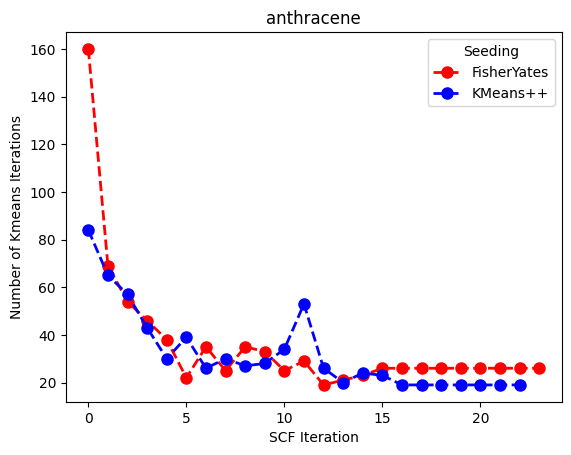

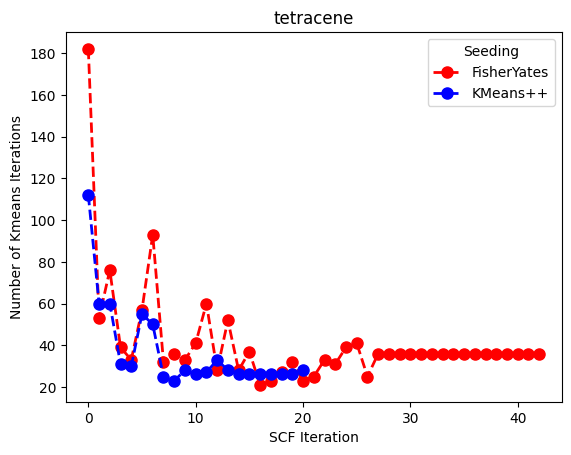

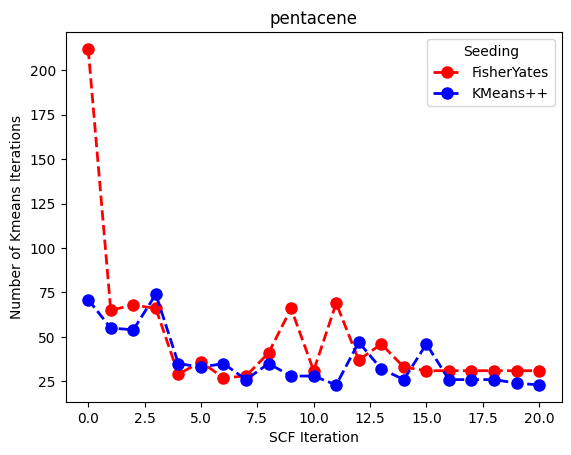

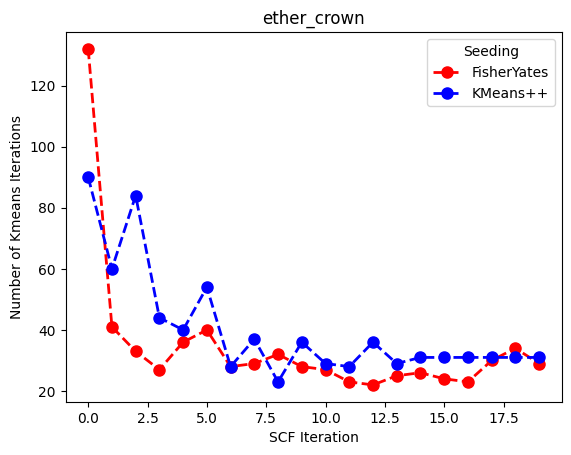

In [5]:
"""Number of K-Means per SCF step vs ACE reference and Fisher-Yates
"""
import matplotlib.pyplot as plt


for molecule in molecules:
    plt.plot(np.arange(len(fy_iters[molecule]), dtype=int), fy_iters[molecule], 'ro--', linewidth=2, markersize=8, label='FisherYates')
    plt.plot(np.arange(len(kmeanspp_iters[molecule]), dtype=int), kmeanspp_iters[molecule], 'bo--', linewidth=2, markersize=8, label='KMeans++')
    plt.xlabel("SCF Iteration")
    plt.ylabel("Number of Kmeans Iterations")
    plt.title(molecule)
    plt.legend(title='Seeding')
    plt.show()
    

In all systems, using k-means++ over (unweighted) random draw of grid points via Fisher Yates, results in far fewer subsequent k-means iterations. Although this trend does not necessarily apply to all SCF steps. One wonders:

### Questions Answered

* Does this result in overall fewer k-means iterations?
    * 3/4 yes. For the ether crown no  

* Does the extra time spent doing k-means++ make up for the savings? 
    * No. On the whole, the current k-means++ algorithm is horrifically slow because it has no OMP dressings over the grid. Currently it takes longer than weighted k-means iterations summed over ALL SCF steps, which is madness.

### Questions to Answer

* If I randomise the seed, run M different seeds in parallel and choose the best, how does it perform?

* Does this require fewer points to achieve the same precision in exact exchange energy?

* Does this work in conjunction with one/both of the convergence criteria I've tested previously, to give an overall better result?

In [11]:
# Total number of k-means iterations in a calculation

molecules =  ["anthracene", "tetracene", "pentacene", "ether_crown"]

print("Molecule |  Fisher-Yates |  K-means++  | Total K-means Itr Change(%)")
print("--------------------------------------------------------------------")
for molecule in molecules:
    nitr_fy = np.sum(fy_iters[molecule])
    nitr_kpp = np.sum(kmeanspp_iters[molecule])
    change = float(nitr_kpp) / float(nitr_fy)
    print(f"{molecule} |   {nitr_fy}      |   {nitr_kpp}   | {change * 100}")

# 

Molecule |  Fisher-Yates |  K-means++  | Total K-means Itr Change(%)
--------------------------------------------------------------------
anthracene |   868      |   742   | 85.48387096774194
tetracene |   1776      |   772   | 43.468468468468465
pentacene |   1040      |   773   | 74.32692307692308
ether_crown |   689      |   804   | 116.69085631349783


In [22]:
# Total time spent in weighted K-means plus initial seeding cost

from isdfbenchmarks.parser.profiling import parse_time

routines = ['WEIGHTED_KMEANS', 'SAMPLE_INITIAL_CENTROIDS']

fy_times = {}
kpp_times = {}

for molecule in molecules:
    cumulative, _ = parse_time(root_kmeans_l2 / molecule / "profiling/time.000000")
    fy_times[molecule] = {r: cumulative[r]['TOTAL_TIME'] for r in routines}
    
    cumulative, _ = parse_time(root_kmeanspp_l2 / molecule / "profiling/time.000000")
    kpp_times[molecule] = {r: cumulative[r]['TOTAL_TIME'] for r in routines}

total_time_fy = {}
print("Molecule  |  FY  , All K-means (over_NSCF) | Sum")
for molecule in molecules:
    t_fy = fy_times[molecule]['SAMPLE_INITIAL_CENTROIDS']
    t_kmeans = fy_times[molecule]['WEIGHTED_KMEANS']
    print(f"{molecule} |  {t_fy}, {t_kmeans} |  {t_fy + t_kmeans}")
    total_time_fy[molecule] = t_fy + t_kmeans

print()

total_time_kpp = {}
print("Molecule  |  KMeans++  , All K-means (over_NSCF) | Sum")
for molecule in molecules:
    t_kpp = kpp_times[molecule]['SAMPLE_INITIAL_CENTROIDS']
    t_kmeans = kpp_times[molecule]['WEIGHTED_KMEANS']
    print(f"{molecule} |  {t_kpp}, {t_kmeans} |  {t_kpp + t_kmeans}")
    total_time_kpp[molecule] = t_kpp + t_kmeans
    
print()

print("Molecule  | Change in Total Time (x)")
print("> 1 implies slower with kmeans++")
for molecule in molecules:
    print(total_time_kpp[molecule] / total_time_fy[molecule], 'X')



Molecule  |  FY  , All K-means (over_NSCF) | Sum
anthracene |  0.002118, 155.334926 |  155.337044
tetracene |  0.002662, 451.222343 |  451.225005
pentacene |  0.002399, 282.783012 |  282.785411
ether_crown |  0.003029, 260.360251 |  260.36328000000003

Molecule  |  KMeans++  , All K-means (over_NSCF) | Sum
anthracene |  213.949004, 137.465617 |  351.414621
tetracene |  279.434554, 163.407079 |  442.841633
pentacene |  644.054134, 276.992152 |  921.046286
ether_crown |  721.153412, 294.214577 |  1015.3679890000001

Molecule  | Change in Total Time (x)
> 1 implies slower with kmeans++
2.262271844184186 X
0.981420861195403 X
3.257050223146059 X
3.899812558053501 X
